In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/"
sys.path.append(PATH_FOR_PROJECT)

SMOKE_TEST = True
RANDOM_STATE_WITHOUT_TEMPERATURES = 32
RANDOM_STATE_WITH_TEMPERATURES = 18

# 1. Preparing the data

In [2]:
import seaborn as sns

In [3]:
iris = sns.load_dataset("iris")

x_n = iris.columns[:-1]
x_2 = iris[x_n].values

X = (x_2 - x_2.mean(axis=0)) / x_2.max(axis=0)

data_classes = list(iris['species'].unique())
y = iris['species'].apply(data_classes.index)

number_of_data = len(y)

# 2. Model without temperatures

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
from utils.timers import TimerContext
from utils.time_profiler_logging import TimeProfilerLogger

In [6]:
from models.classification.classification_bayesian_softmax_temperature import \
    BayesianSoftmaxClassificationWithTemperatures
from models.classification.classification_bayesian_softmax import BayesianSoftmaxClassification
from models.calibration.diagnostics import calculate_static_calibration_error

In [7]:
from data_handling.train_test_split import return_train_test_split_indexes

In [8]:
logger_time = TimeProfilerLogger.getInstance()

In [9]:
with TimerContext(name="without_temperature",
                  show_time_when_exit=True,
                  logger=logger_time) as timer:

    train_indexes, test_indexes = return_train_test_split_indexes(number_of_data,
                                                                  test_size=0.3,
                                                                  random_state=RANDOM_STATE_WITHOUT_TEMPERATURES)

    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], \
                                       y.values[train_indexes], y.values[test_indexes]

    model_without = BayesianSoftmaxClassification(number_of_classes=3,
                                                  number_of_features=4,
                                                  X_train=X_train,
                                                  y_train=y_train)

    model_without.params.number_of_tuning_steps = 5000 if not SMOKE_TEST else 10
    model_without.params.number_of_samples_for_posterior = int(1e5) if not SMOKE_TEST else 10
    model_without.params.number_of_iterations = int(1e6) if not SMOKE_TEST else 10

    model_without.sample()
    #model_without.show_trace()

    predictions = model_without.make_predictions(X_test, y_test)

    y_test_predictions, confidences = predictions.predictions_with_confidence

    accuracy_without_temperatures = 100.0 * accuracy_score(y_test, predictions.predictions)

    curves_without_temperatures, means_per_bin_without_temperatures, deviation_score_without_temperatures = calculate_static_calibration_error(y_test_predictions,
                                                                                                y_test,
                                                                                                confidences,
                                                                                                predictions.number_of_classes)


Average Loss = 121.08: 100%|██████████| 10/10 [00:00<00:00, 364.24it/s]
Finished [100%]: Average Loss = 115.53
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, theta_0]
Sampling 4 chains: 100%|██████████| 80/80 [00:00<00:00, 780.78draws/s]
/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
100%|██████████| 1000/1000 [00:13<00:00, 75.49it/s]

Method: without_temperature | Elapsed time: 103.76s


# 3. Model with temperatures

In [10]:
with TimerContext(name="with_temperature", show_time_when_exit=True) as timer:

    train_indexes, test_indexes = return_train_test_split_indexes(number_of_data,
                                                                  test_size=0.3,
                                                                  random_state=RANDOM_STATE_WITH_TEMPERATURES)

    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], \
                                       y.values[train_indexes], y.values[test_indexes]

    model_with = BayesianSoftmaxClassificationWithTemperatures(number_of_classes=3,
                                                               number_of_features=4,
                                                               X_train=X_train,
                                                               y_train=y_train)

    model_with.params.number_of_tuning_steps = 5000 if not SMOKE_TEST else 10
    model_with.params.number_of_samples_for_posterior = int(1e5) if not SMOKE_TEST else 10
    model_with.params.number_of_iterations = int(1e6) if not SMOKE_TEST else 10

    model_with.sample()
    #model_with.show_trace()

    print(logger_time.times)

    predictions = model_with.make_predictions(X_test, y_test)

    y_test_predictions, confidences = predictions.predictions_with_confidence

    accuracy_with_temperatures = 100.0 * accuracy_score(y_test, predictions.predictions)

    curves_with_temperatures, means_per_bin_with_temperatures, deviation_score_with_temperatures = calculate_static_calibration_error(y_test_predictions,
                                                                                          y_test,
                                                                                          confidences,
                                                                                          predictions.number_of_classes)


Average Loss = 156.09: 100%|██████████| 10/10 [00:00<00:00, 2132.12it/s]
Finished [100%]: Average Loss = 135.33
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperatures, thetas, theta_0]
Sampling 4 chains: 100%|██████████| 80/80 [00:00<00:00, 240.91draws/s]
/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.369227972782, but should be close to 0.8. Try to increase the number of tuning steps.
  0%|          | 0/1000 [00:00<?, ?it/s]

Method: sampling | Elapsed time: 8.78s
{'without_temperature': 103.76214051246643, 'sampling': 8.776987314224243}


100%|██████████| 1000/1000 [00:13<00:00, 72.31it/s]

Method: with_temperature | Elapsed time: 25.63s


# 4. Analysis of the results

In [11]:
import pymc3 as pm
import numpy as np

In [12]:
from visualisations.visualisations import Visualisator

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


                         WAIC   pWAIC    dWAIC weight      SE     dSE var_warn
without temperatures   152.78    3.21        0   0.84   13.84       0        0
with temperatures     2075.62  820.03  1922.83   0.16  301.64  302.93        1


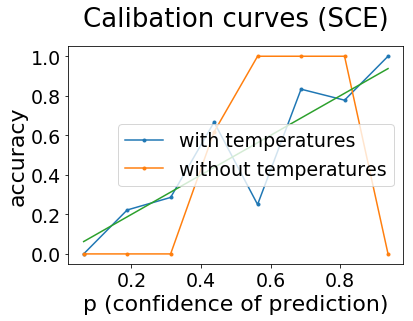

In [13]:
model_with.model.name = 'with temperatures'
model_without.model.name = 'without temperatures'

df_compare_WAIC = pm.compare({model_with.model: model_with.trace,
                           model_without.model: model_without.trace})

print(df_compare_WAIC)


Visualisator.show_calibration_curves(means_per_bin_with_temperatures,
                                     np.array([curves_with_temperatures,
                                      curves_without_temperatures]),
                                     ["with temperatures", "without temperatures"],
                                     title_suffix="(SCE)"
                                     )

In [14]:
print("acc without: {}".format(accuracy_without_temperatures))
print("acc with: {}".format(accuracy_with_temperatures))
print("dev without: {}".format(deviation_score_without_temperatures))
print("dev with: {}".format(deviation_score_with_temperatures))

acc without: 93.33333333333333
acc with: 86.66666666666667
dev without: 0.07268518518518519
dev with: 0.038425925925925926
